In [76]:
from functools import lru_cache, partial
from collections import defaultdict, deque, namedtuple
from datetime import timedelta
import csv
import pickle
from pathlib import Path
from glob import glob
import re
import random
import math
import numpy as np
from scipy import stats, special
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sortedcontainers import SortedList, SortedDict, SortedSet
from pyfaidx import Fasta
from Bio import SeqIO
import mmh3
from pafpy import PafFile
import intervaltree as itree

plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams["figure.dpi"] = 400
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}

# Formulas for calculating minmer density

In [ ]:
@lru_cache(maxsize=None)
def prerr(w, r1, rw, ss):
    acc = 0
    dist = stats.hypergeom(w-1, r1-1, w-rw)
    if r1 <= ss or rw <= ss:
        return 1
    for u in range(1, min(r1 -1, w-rw)+1):
        if 2*u + rw - r1 >= u and u + rw - ss >= 0:
            path_prob = math.comb(2*u + rw - r1, u+rw -ss) / math.comb(2*u + rw -r1, u)
            hgeom_prob = dist.pmf(u)
            if path_prob > 1:
                print(f"u={u}, r1={r1}, rw={rw}, p={path_prob:.3f}")
            acc += hgeom_prob*path_prob
    return acc

@lru_cache(maxsize=None)
def minmer_density_w(w, ss, use_tqdm=True):
    adata = np.arange(0, w-1, dtype=int)
    ranks = np.arange(1, w+1, dtype=int)
    acc = []
    for r in (tqdm(ranks) if use_tqdm else ranks):
        alpha = r
        beta = w - r + 1
        betaBinDist = stats.betabinom(w-1, alpha, beta)
        if r <= ss:
            acc.append(1/len(ranks))
        else:
            eps = .001
            amin = int(betaBinDist.ppf(eps))
            amax = int(betaBinDist.ppf(1-eps)) + 1
            acc.append(sum([
                (betaBinDist.pmf(a)*(prerr(w, r, a+1, ss) if a >= ss else 1)) for a in range(amin, min(amax, w-(r - ss)))
            ]) /  len(ranks))
            if (w-r)*acc[-1] <= eps:
                break
    return sum(acc)

# Figure 3

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

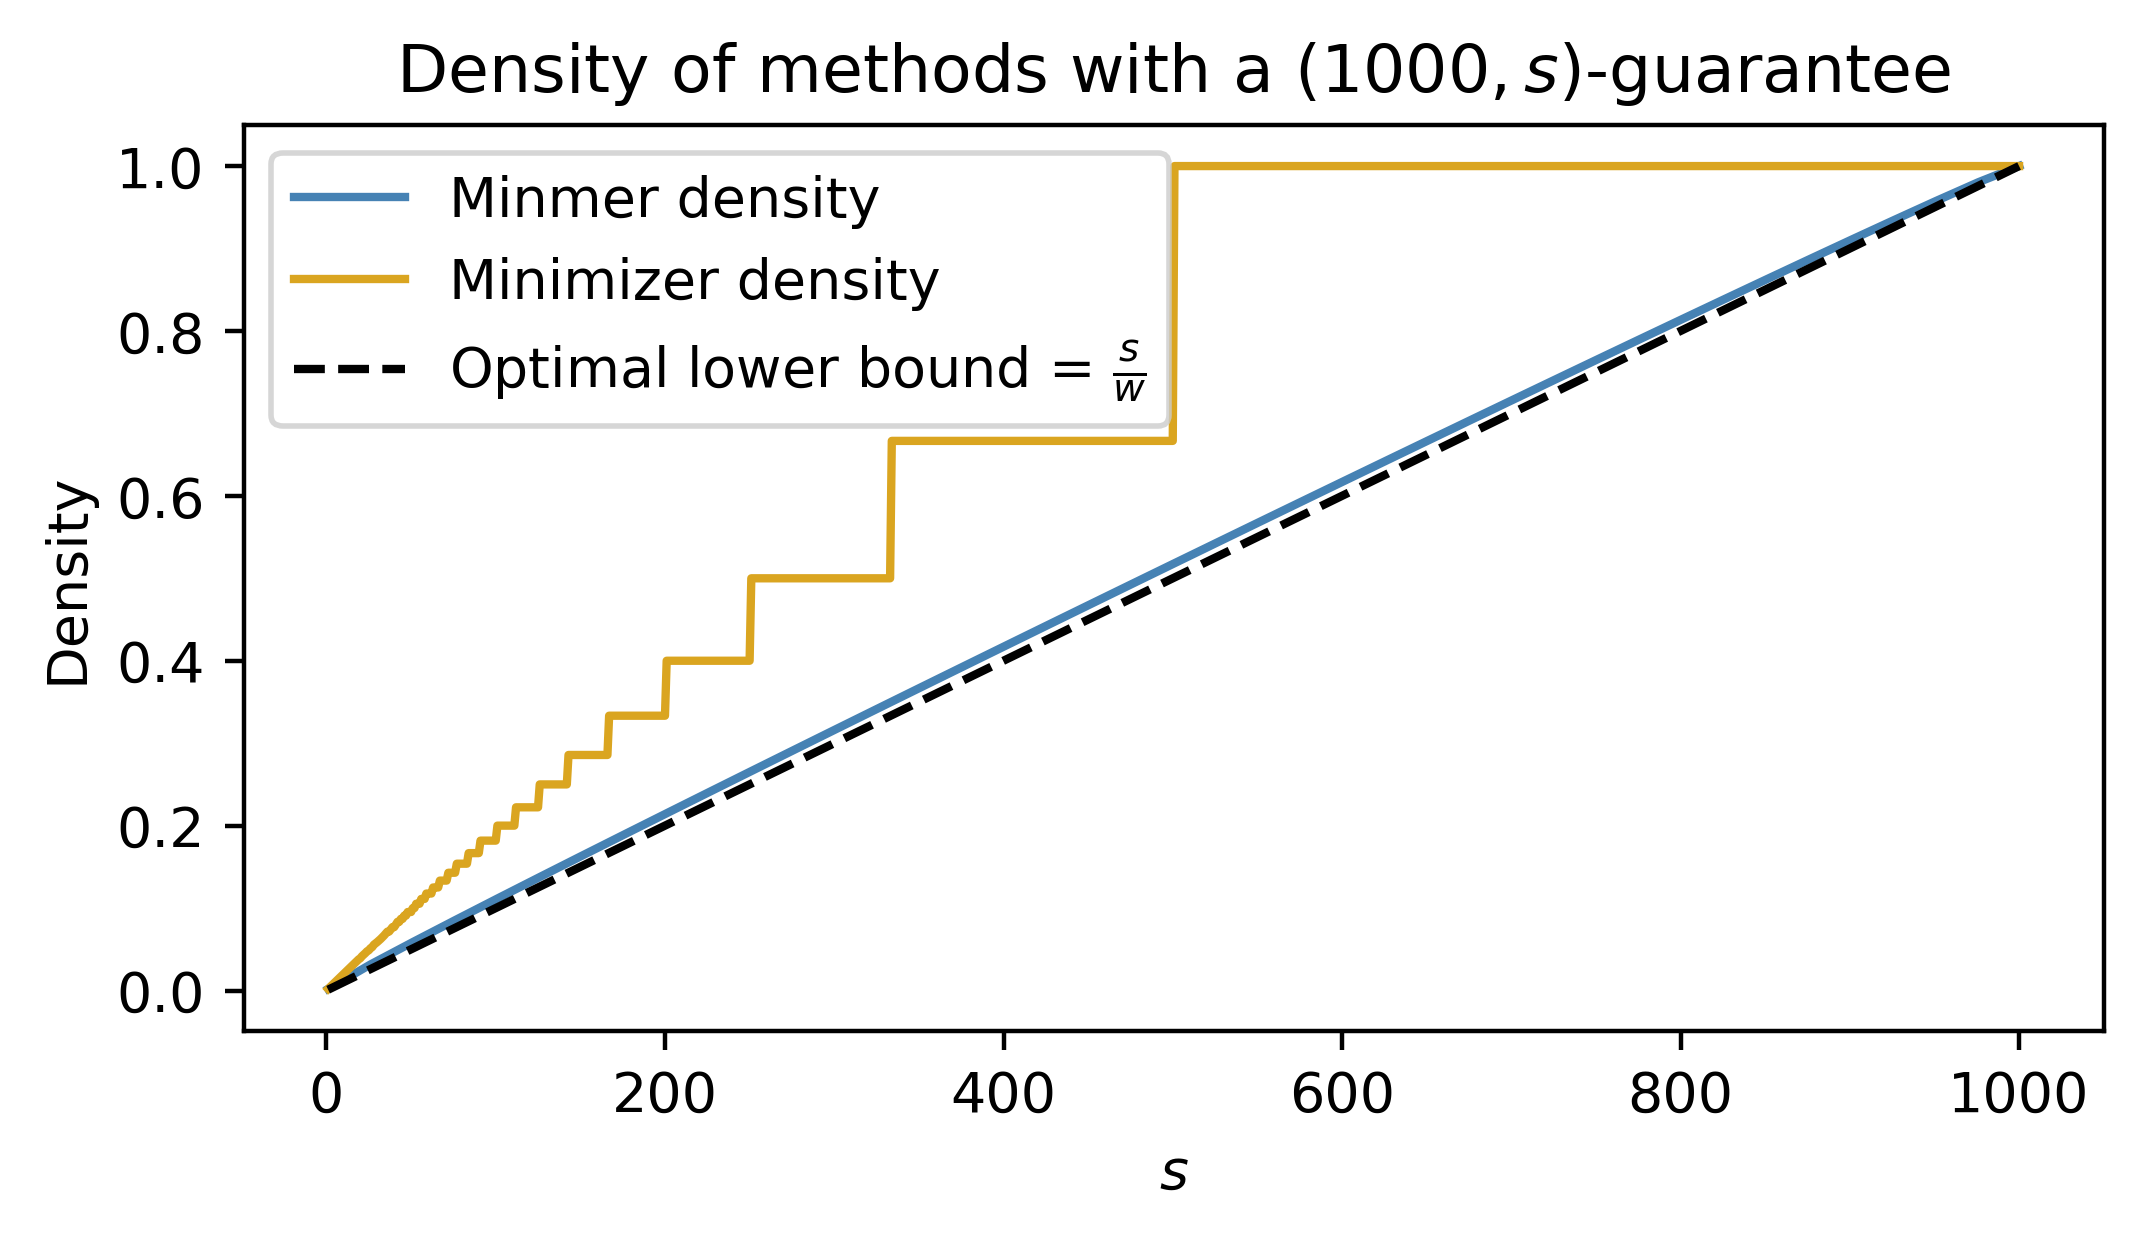

In [87]:
w = 1000
exact = []
minimizerFixedSS = []
minimizer_sses = list(range(1, w+1, 1))
minmer_sses = list(range(1, w+1, 25)) + [w]

for ss in tqdm(minimizer_sses):
    minimizer_w = math.floor(w/ss)
    minimizerFixedSS.append(2/((minimizer_w)+1))
    
for ss in tqdm(minmer_sses):
    exact.append(minmer_density_w(w, ss, use_tqdm=False))
    
plt.title(f"Density of methods with a $({w},s)$-guarantee")
plt.xlabel("$s$")
plt.ylabel("Density")
plt.plot(minmer_sses, np.array(exact), label='Minmer density', color="steelblue")
plt.plot(minimizer_sses, np.array(minimizerFixedSS), label='Minimizer density', color="goldenrod")
plt.plot(minimizer_sses, [ss/w for ss in minimizer_sses], linestyle="dashed",  label='Optimal lower bound = $\\frac{s}{w}$', color="black")
plt.legend()
plt.show()

# Figure 4

In [3]:
human_ref = "/home/Users/blk6/Data/assemblies/human/T2T_v2.1.fna"
target_fai = Fasta(human_ref)
target_index = SeqIO.index(human_ref, "fasta")

In [4]:
kmer_size = 18
SEED=42
genome_seq = str(target_index["chrY"].seq).upper()
genome_hashes = [mmh3.hash64(genome_seq[i:i+kmer_size], seed=SEED, signed=False) for i in tqdm(range(len(genome_seq) - kmer_size + 1))]
N = len(genome_hashes)
simulated_hashes = random.choices(range(0, 2**60), k=N)

  0%|          | 0/62460012 [00:00<?, ?it/s]

In [5]:
s_list = [10, 50, 100, 200]
w = 1000

ss_to_sketched = {
    "simulated": {s: np.zeros(len(genome_hashes), dtype=bool) for s in s_list},
    "empirical": {s: np.zeros(len(simulated_hashes), dtype=bool) for s in s_list}
}


for hash_seq, name in [(simulated_hashes, "simulated"), (genome_hashes, "empirical")]:
    N = len(hash_seq)
    active_counter = defaultdict(deque)
    sorted_window = SortedSet((h) for (idx, h) in enumerate(hash_seq[:w]))
    for i, h in enumerate(hash_seq[:w]):
        active_counter[h].append(i)
        # index_to_rank[i] = sorted_window.bisect_left(((genome_hashes[i]) + 1))
    for i in tqdm(range(1, N-w+1)):
        active_counter[hash_seq[i-1]].popleft()
        active_counter[hash_seq[i + w - 1]].append(i+w-1)
        if len(active_counter[hash_seq[i-1]]) == 0:
            sorted_window.discard(hash_seq[i-1])
            del active_counter[hash_seq[i-1]]
        sorted_window.add(hash_seq[i + w - 1])

        assert(len(active_counter) == len(sorted_window))
        for s in s_list:
            cutoff = sorted_window[min(s-1, len(sorted_window)-1)]

            # Check if new hash in in sketch
            if hash_seq[i + w - 1] <= cutoff:
                sidx = active_counter[hash_seq[i + w - 1]][0]
                ss_to_sketched[name][s][sidx] = True 

            # Check if old hash in in sketch
            if hash_seq[i - 1] <= cutoff and hash_seq[i - 1] in active_counter:
                sidx = active_counter[hash_seq[i - 1]][0]
                ss_to_sketched[name][s][sidx] = True 

            sketch_border_elem = active_counter[sorted_window[min(s-1, len(sorted_window)-1)]][0]
            ss_to_sketched[name][s][sketch_border_elem] = True
        

  0%|          | 0/62459012 [00:00<?, ?it/s]

  0%|          | 0/62459012 [00:00<?, ?it/s]

In [6]:
def minimizer(nums, w):
    """
    :type nums: List[int]
    :type k: int
    :rtype: List[int]
    """
    d = deque()
    out = []
    for i, n in tqdm(list(enumerate(nums))):
        while d and nums[d[-1]] > n:
            d.pop()
        d.append(i)
        if d[0] == i - w:
            d.popleft()
        if i>=w-1:
            out.append(d[0])
    return out

def minimizerWindowLen(density):
    return 2/density -1

34.0
Theoretical minmer density =  0.058, actual density =  0.060


  0%|          | 0/62460012 [00:00<?, ?it/s]

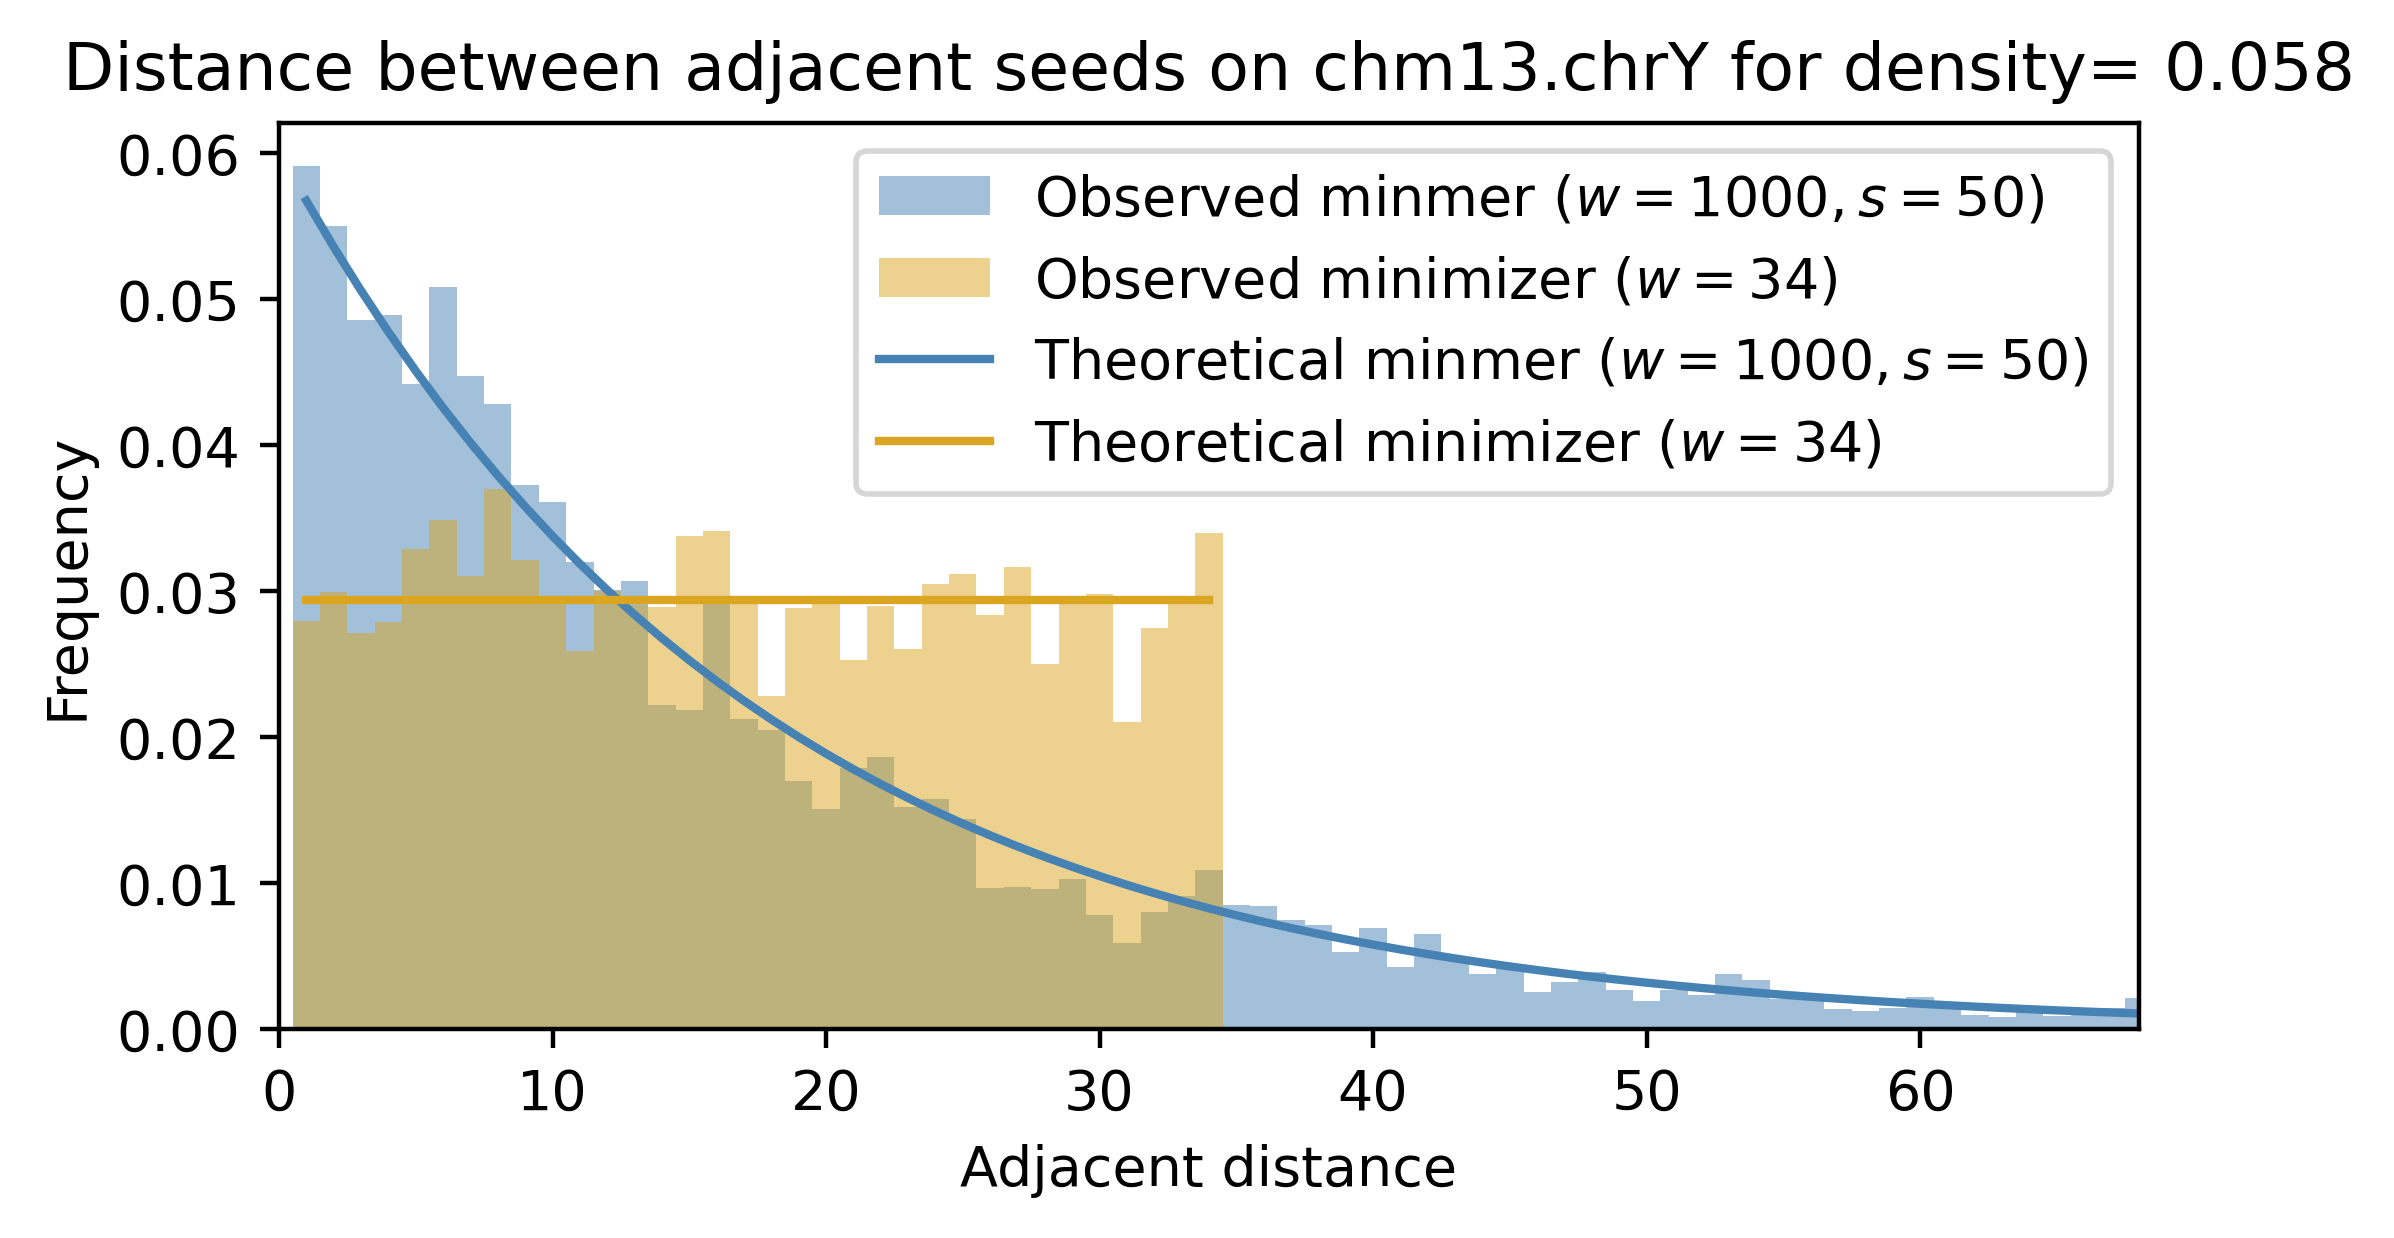

34.0
Theoretical minmer density =  0.058, actual density =  0.058


  0%|          | 0/62460012 [00:00<?, ?it/s]

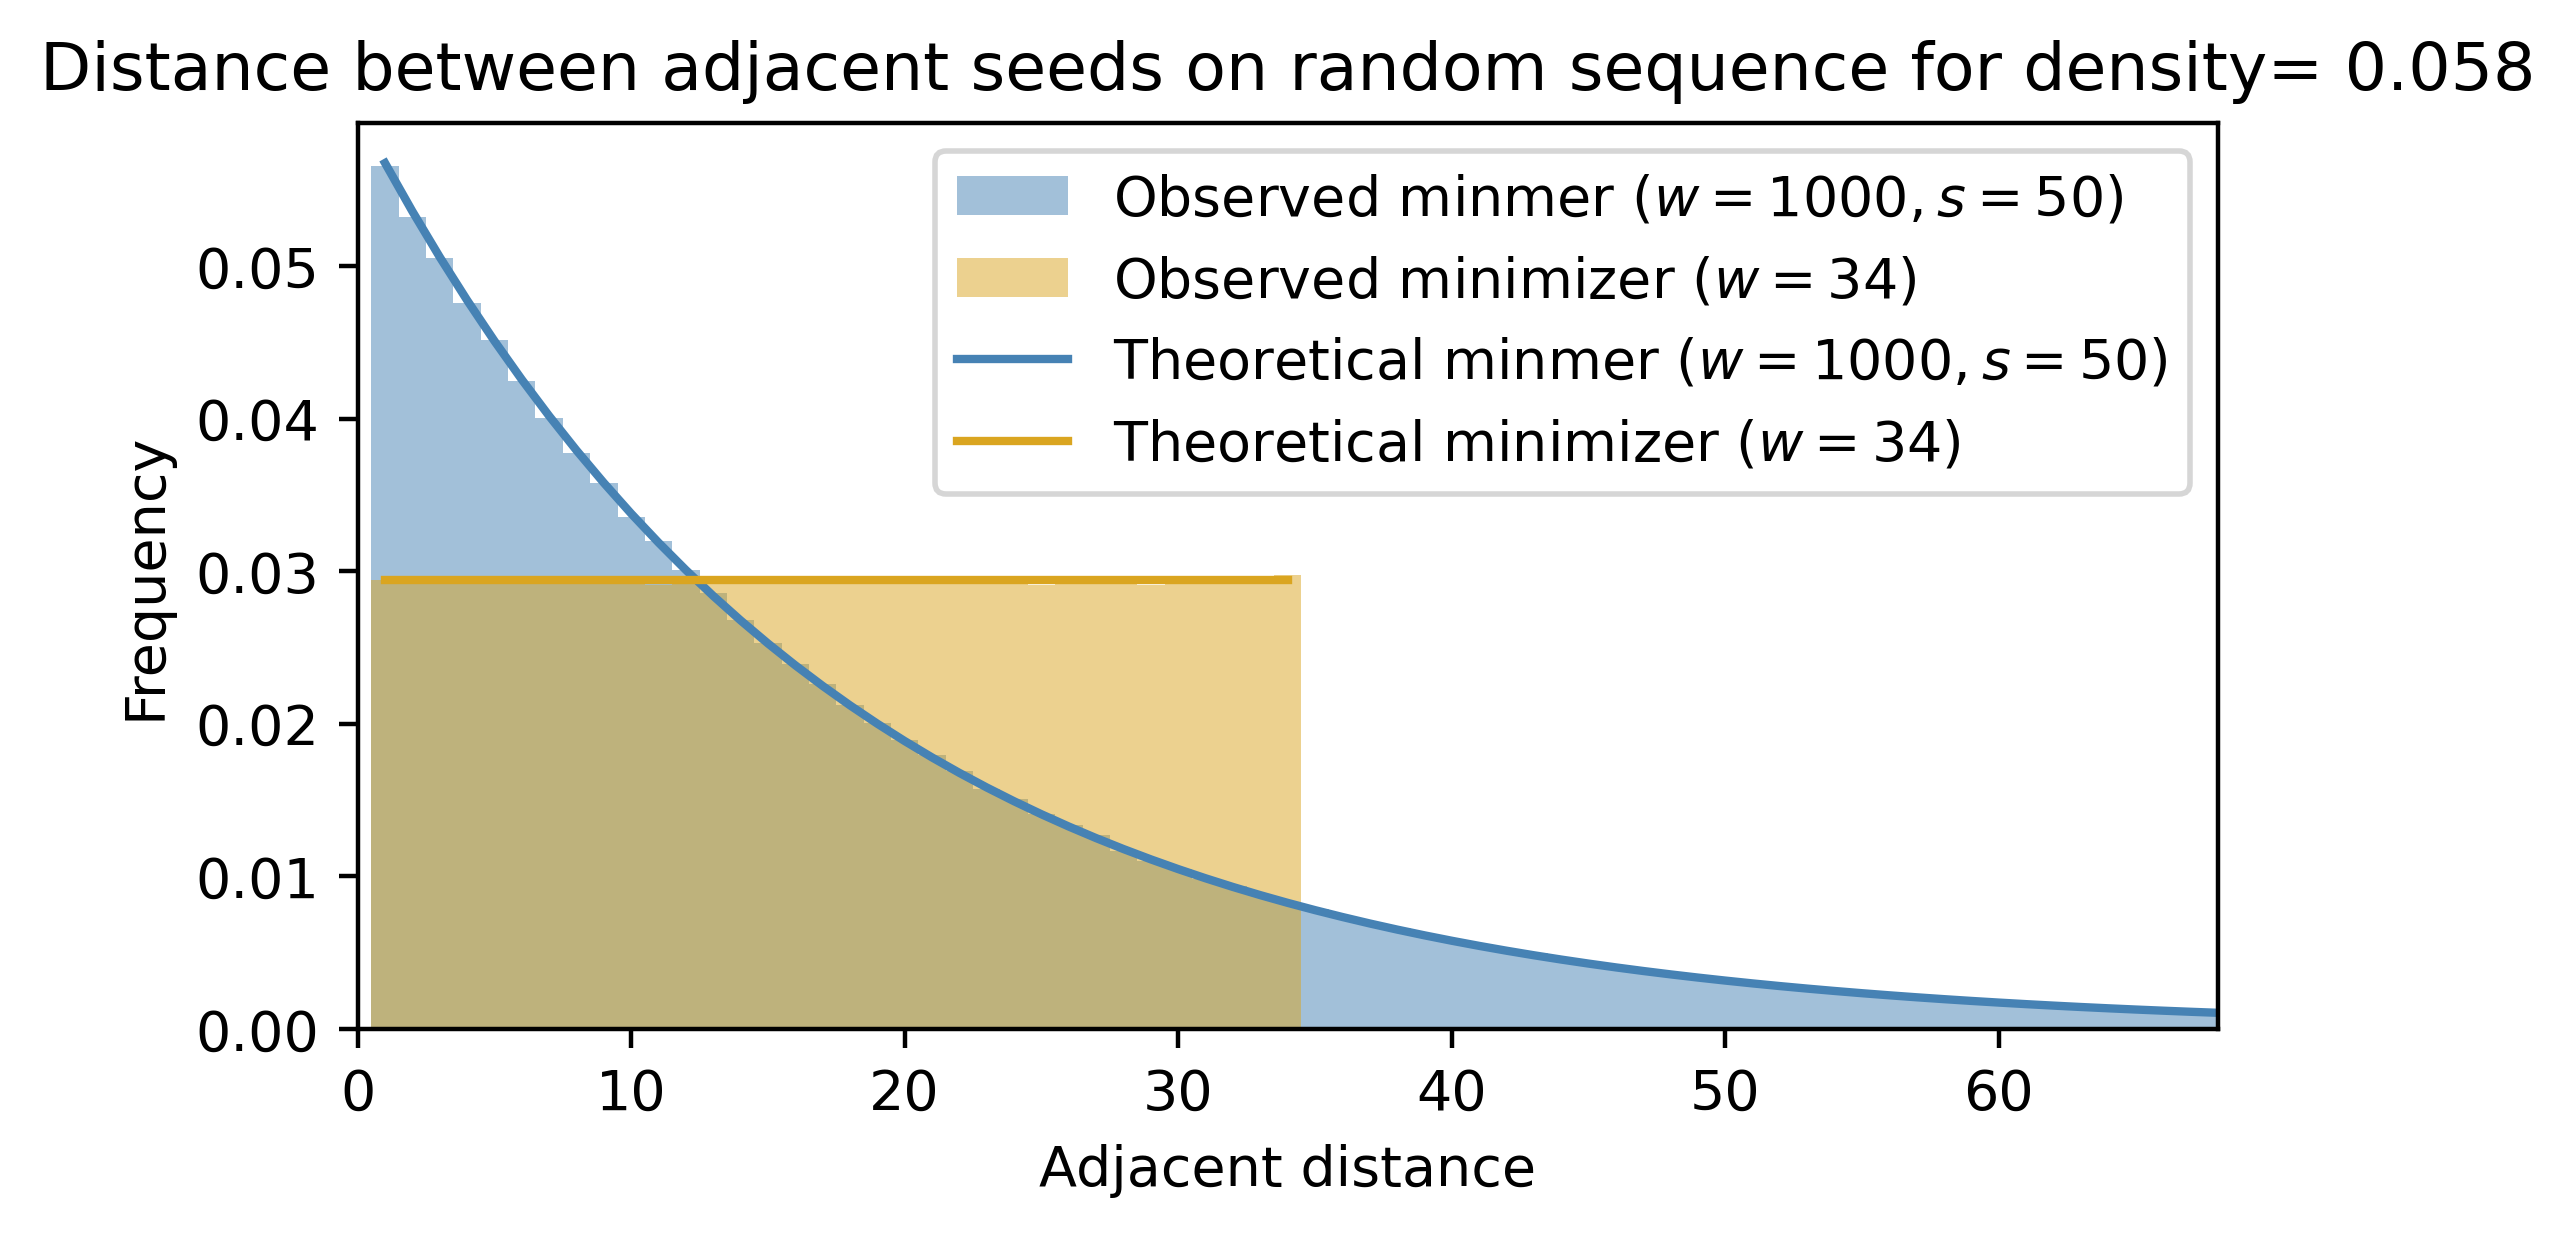

In [24]:
ss = 50

for dataset, seqName in [("empirical", "chm13.chrY"), ("simulated", "random sequence")]:
    ssts = ss_to_sketched[dataset][ss]
    hash_seq = simulated_hashes if dataset == "simulated" else genome_hashes

    minmer_density = minmer_density_w(w, ss)

    corresponding_minimizer_w = np.round(minimizerWindowLen(minmer_density))
    print(corresponding_minimizer_w)
    minmer_sketched_idx_list = sorted(ssts.nonzero()[0])
    print(f"Theoretical minmer density = {minmer_density : .3f}, actual density = {len(minmer_sketched_idx_list)/len(hash_seq) : .3f}")
    minmer_dist_list = [minmer_sketched_idx_list[i] - minmer_sketched_idx_list[i-1] for i in range(1, len(minmer_sketched_idx_list))]
    max_w = int(max(minmer_dist_list)) + 1

    minimizer_sketched_idx_list = sorted(set(minimizer(hash_seq, corresponding_minimizer_w)))
    minimizer_dist_list = [minimizer_sketched_idx_list[i] - minimizer_sketched_idx_list[i-1] for i in range(1, len(minimizer_sketched_idx_list))]

    minmer_df = minmer_density * (w+1)

    sample_size = int(min(1e6, len(minmer_dist_list), len(minimizer_dist_list)))
    binsize=1
    # plt.xlim(-1, k+5)

    plt.title(f"Distance between adjacent seeds on {seqName} for density={minmer_density : 0.3f}")
    minmer_hist = plt.hist(random.sample(minmer_dist_list, sample_size), bins=range(0, max_w+1, binsize), alpha=.5, density=True, color="steelblue", label=f"Observed minmer $(w={w}, s={ss})$", align="left")
    minimizer_hist = plt.hist(random.sample(minimizer_dist_list, sample_size), alpha=.5, bins=range(0, max_w+1, binsize), density=True, color="goldenrod",  label=f"Observed minimizer $(w={int(corresponding_minimizer_w)})$", align="left")

    Ds = range(1,int(3*corresponding_minimizer_w))
    minimizer_Ds = range(1,int(corresponding_minimizer_w)+1)
    plt.plot(Ds, [special.comb(w-d, max(0, minmer_df-2)) / special.comb(w, minmer_df-1) for d in Ds], color="steelblue", label=f"Theoretical minmer $(w={w}, s={ss})$")
    plt.plot(minimizer_Ds, [1/corresponding_minimizer_w if d < corresponding_minimizer_w+1 else 0 for d in minimizer_Ds], color="goldenrod", label=f"Theoretical minimizer $(w={int(corresponding_minimizer_w)})$")
    plt.legend()
    plt.xlim(0, 2*corresponding_minimizer_w)
    plt.ylim(0, max(max(minmer_hist[0]), max(minimizer_hist[0]))*1.05)
    plt.xlabel("Adjacent distance")
    plt.ylabel("Frequency")
    plt.show()


# Figure 5
* Datasets available from Belbasi et al. [here](https://github.com/medvedevgroup/minimizer-jaccard-estimator)
* MashMap2 (modified to use the binomial model) and MashMap3 were run with a segment length of 10,000 and a kmer size of 19. All other parameters were set to the default.
* Averages can be obtained from a paf file via

```bash
alias computeAvg="awk '{ sum += \$1; n++ } END { if (n > 0) print sum / n; }'"
cut $PAF -f13 | computeAvg
```

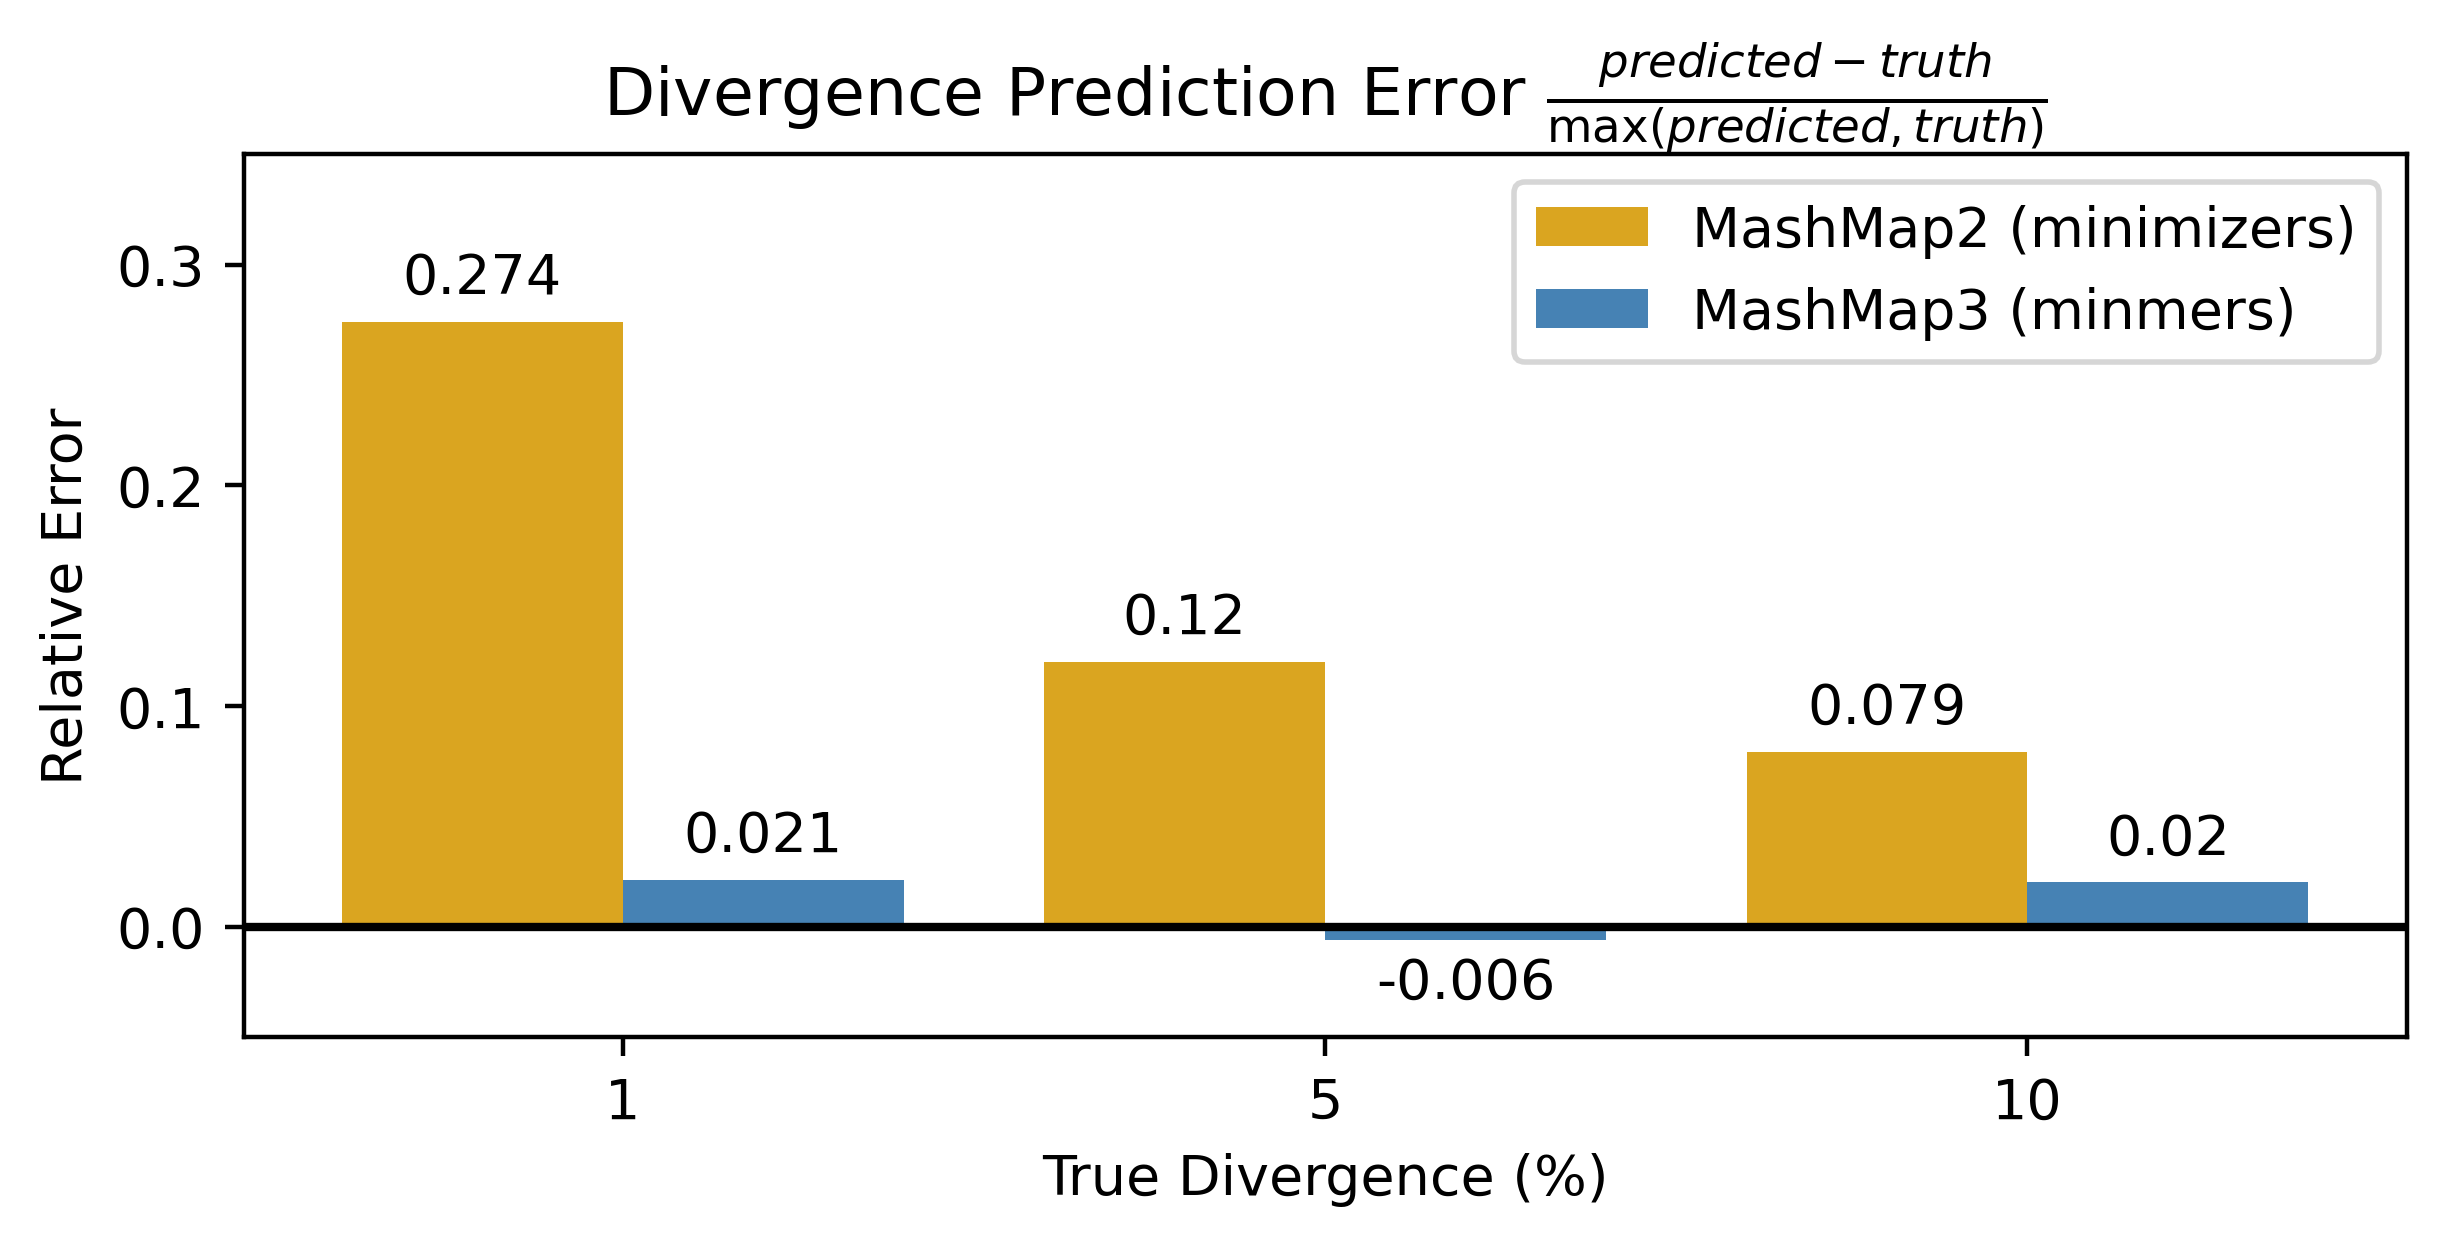

In [30]:
bb_results = {
    "1": {"MashMap2": 0.274, "MashMap3": 0.021},
    "5": {"MashMap2": 0.120, "MashMap3": -0.006},
    "10": {"MashMap2": 0.079, "MashMap3": 0.020}}

tools = ["MashMap2", "MashMap3"]
tool_to_label = {"MashMap2": "MashMap2 (minimizers)", "MashMap3": "MashMap3 (minmers)"}
tool_to_color = {"MashMap2": "goldenrod", "MashMap3": "steelblue"}
divs = [1, 5, 10]
x = np.arange(3)  # the label locations
width = 0.4 # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for tool in tools:
    offset = width * multiplier
    rects = ax.bar(x + offset, [d[tool] for d in bb_results.values()], width, label=tool_to_label[tool], color=tool_to_color[tool])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative Error')
ax.set_xlabel("True Divergence (%)")
ax.set_title(r'Divergence Prediction Error $\frac{predicted - truth}{\max(predicted, truth)}$')
ax.set_xticks(x + width/2, divs)
ax.legend()
ax.axhline(0, color="black")
ax.set_ylim((-.05, 0.35))

plt.show()

# Tables 1 and 2

The following cell contains the function used to parse the output of `/usr/bin/time -v`

In [77]:
import re

PerformanceProfile = namedtuple("PerformanceProfile", ["cputime", "walltime", "memory"])
BasicAlignment =  namedtuple("BasicAlignment", ["length", "ANI_est", "ANI_wfmash"])


def file_to_profile(input_f):
    kbInGb = 1048576
    user, sys, walltime, cputime, memory = 0, 0, 0, 0, 0
    if not Path(input_f).exists():
        # print(input_f)
        return None
    with open(input_f) as profile_in:
        for line in profile_in:
            m = re.search(r'User time \(seconds\): (?P<time>\d+\D\d+)', line)
            if m:
                user = float(m.groupdict()["time"])
                continue
            m = re.search(r'System time \(seconds\): (?P<time>\d+\D\d+)', line)
            if m:
                sys = float(m.groupdict()["time"])
                continue
            m = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?P<time>\d+:\d+:\d+)', line)
            if m:
                h, mm, ss = m.groupdict()["time"].split(":")
                walltime = timedelta(seconds=float(ss), minutes=float(mm), hours=float(h))
                continue
            m = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (?P<time>\d+:\d+.\d+)', line)
            if m:
                mm, ss = m.groupdict()["time"].split(":")
                walltime = timedelta(seconds=float(ss), minutes=float(mm))
                continue
            m = re.search(r'Maximum resident set size \(kbytes\): (?P<mem>\d+)', line)
            if m:
                memory = int(m.groupdict()["mem"])
                continue
            
            m = re.search(r'Exit status: (?P<status>\d+)', line)
            if m:
                if m.groupdict()["status"] != "0":
                    return None
                continue
        cputime = timedelta(seconds=user+sys)
    return PerformanceProfile(np.round(cputime.total_seconds() / 60, 2), np.round(walltime.total_seconds() / 60, 2), np.round(memory / kbInGb, 2)) if (cputime and walltime and memory) else None

def print_profile(tool_to_profile):
    print(f"{'Method': ^40}\t{'CPU time (m)' : ^8}\t{'Wall time (m)' : ^8}\t{'Memory (GiB)' : ^8}")
    for tool, prof in tool_to_profile.items():
        if not prof:
            print(f"{tool.name: <20}t{tool.pi : <4}\t{tool.ss : <4}\t{'...' : <8}\t{'...' : <8}\t{'...' : <8}")
        else:
            print(f"{tool.name: <20}\t{tool.pi : <4}\t{tool.ss : <4}\t{prof.cputime : <8}\t{prof.walltime : <8}\t{prof.memory : <8}")

## Table 1

The following script was used to generate the reads for Table 1

```bash
#/usr/bin/env bash
for ANI in 95 98 99; do
    NAME="ONT-${ANI}"
    pbsim \
        --prefix pbsim/${name} \
        --length-mean 5000 --length-min 5000 --length-max 5000 \
        --accuracy-mean .${ANI} --accuracy-sd 0 \
        --model_qc ${CLR_PROFILE} \
        --depth 2 \
        --difference-ratio 20:40:40 \
        ${T2T_FASTA}
    paftools.js pbsim2fq ${T2T_FAI} pbsim/${NAME}_*.maf > ${NAME}.fa
    shuffle.sh in=${name}.fa out=${NAME}.shuffled.fa
    mv ${NAME}.shuffled.fa ${NAME}.fa
done

```

In [ ]:
# Code used to compute the ground truth gap-compressed ANI of the simulated sequences.
def get_gcANI_J(maf_files, jaccard_frac, k=19):
    gap_regex = re.compile(r'(-)+')
    rid_to_gcANI = {}
    rid_to_J = {}
    for maf_file in tqdm(maf_files):
        counter = 0
        num_lines = sum(1 for line in open(maf_file))
        for line_no, line in (enumerate(line.strip() for line in open(maf_file))):
            if line == "":
                continue
            if line[0] == "a":
                if counter == 2:
                    match_columns = sum(ref_aln[i] == query_aln[i] for i in range(len(query_aln)))
                    s = query_aln + "SEP" + ref_aln
                    gap_columns_compressed_extra = s.count("-") - len(gap_regex.findall(s))
                    total_columns = len(ref_aln)
                    
                    ## Code for computing the jaccard. Very expensive, so only compute on subset
                    if random.random() <= jaccard_frac:
                        ref_aln = ref_aln.replace("-", "")
                        query_aln = query_aln.replace("-", "")
                        ref_set = set(ref_aln[i:i+k] for i in range(len(ref_aln)-k+1))
                        query_set = set(query_aln[i:i+k] for i in range(len(query_aln)-k+1))
                        rid_to_J[rid] = len(ref_set & query_set) / len(ref_set | query_set) 
                    
                    rid_to_gcANI[rid] = 100*match_columns / (total_columns - gap_columns_compressed_extra)
                counter = 0
            elif line[0] == "s" and counter == 0:
                counter += 1
                ref_aln = line.split(" ")[-1].upper()
            elif line[0] == "s" and counter == 1:
                rid = line.split(" ")[1]
                query_aln = line.split(" ")[-1].upper()
                counter += 1
    return rid_to_gcANI, rid_to_J

for ANI in [95, 98, 99]:
    maf_files = glob(f"/home/Users/blk6/Data/reads/human/pbsim/ONT-{ANI}-nosd-balanced-d2-5000_00*.maf")
    print(ANI)
    ANI_to_gcANI[ANI], ANI_to_J[ANI] = get_gcANI_J(maf_files, 0)
    print(stats.describe(list(ANI_to_gcANI[ANI].values())))
    

## Table 2

The following will obtain the mean error and mean absolute error on a paf file aligned with `wfmash`. Note that this does not discard low complexity regions as in the paper. 

```bash
alias computeME="awk '{ sum += \$1; n++ } END { if (n > 0) print sum / n; }'"
alias computeMAE="awk '{ sum += (\$1 > 0 ? \$1 : -\$1); n++ } END { if (n > 0) print sum / n; }'"
cat  ${ALIGNED_PAF} | awk '{split($13, gi, ":"); split($15, md, ":"); print (md[3]-gi[3]);}' | computeME
cat  ${ALIGNED_PAF} | awk '{split($13, gi, ":"); split($15, md, ":"); print (md[3]-gi[3]);}' | computeMAE
```

In [433]:
def index_fasta(fasta_file):
    return {record.id: record.seq.upper() for record in (SeqIO.parse(fasta_file, "fasta"))}

human_index = index_fasta("/home/Users/blk6/Data/assemblies/human/T2T_v2.1.fna")
chimp_index = index_fasta("/home/Users/blk6/Data/assemblies/chimpanzee/Clint_PTRv2.fna")
macaque_index =  index_fasta("/home/Users/blk6/Data/assemblies/macaque/GCF_003339765.1_Mmul_10_genomic.fna")

name_to_index = {
    "human": human_index,
    "chimpanzee": chimp_index,
    "macaque": macaque_index
}

In [513]:
# Get the complexity of a sequence
def get_seq_complexity(seq, k=19):
    kmers = set(str(seq[i:i+k]) for i in range(len(seq) - k + 1))
    return len(kmers) / (len(seq) - k + 1)

# Return the minimum complexity between two sequences
# where r is a record for the PafPy 
def get_min_complexity(ref, query, r, k=19):
    tseq = name_to_index[ref][r.tname][r.tstart:r.tend]
    qseq = name_to_index[query][r.qname][r.qstart:r.qend]
    return min(
        get_seq_complexity(tseq, k),
        get_seq_complexity(qseq, k))

def get_jaccard_similarity(tseq, qseq, r, k=19):
    tkmers = set(str(tseq[i:i+k]) for i in range(len(tseq) - k + 1))
    qkmers = set(str(qseq[i:i+k]) for i in range(len(qseq) - k + 1))
    return len(tkmers & qkmers) / len(tkmers | qkmers)

In [ ]:
file_to_profile(f"/home/Users/blk6/Contribute/wfmash/output-pafs-nomerge/human-chimpanzee/human-chimpanzee.L5000.ss150.p85.mashmap2.approx.err")

PerformanceProfile(cputime=503.27, walltime=59.39, memory=36.75)

# Supplemental Figures

## Table 2

95


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

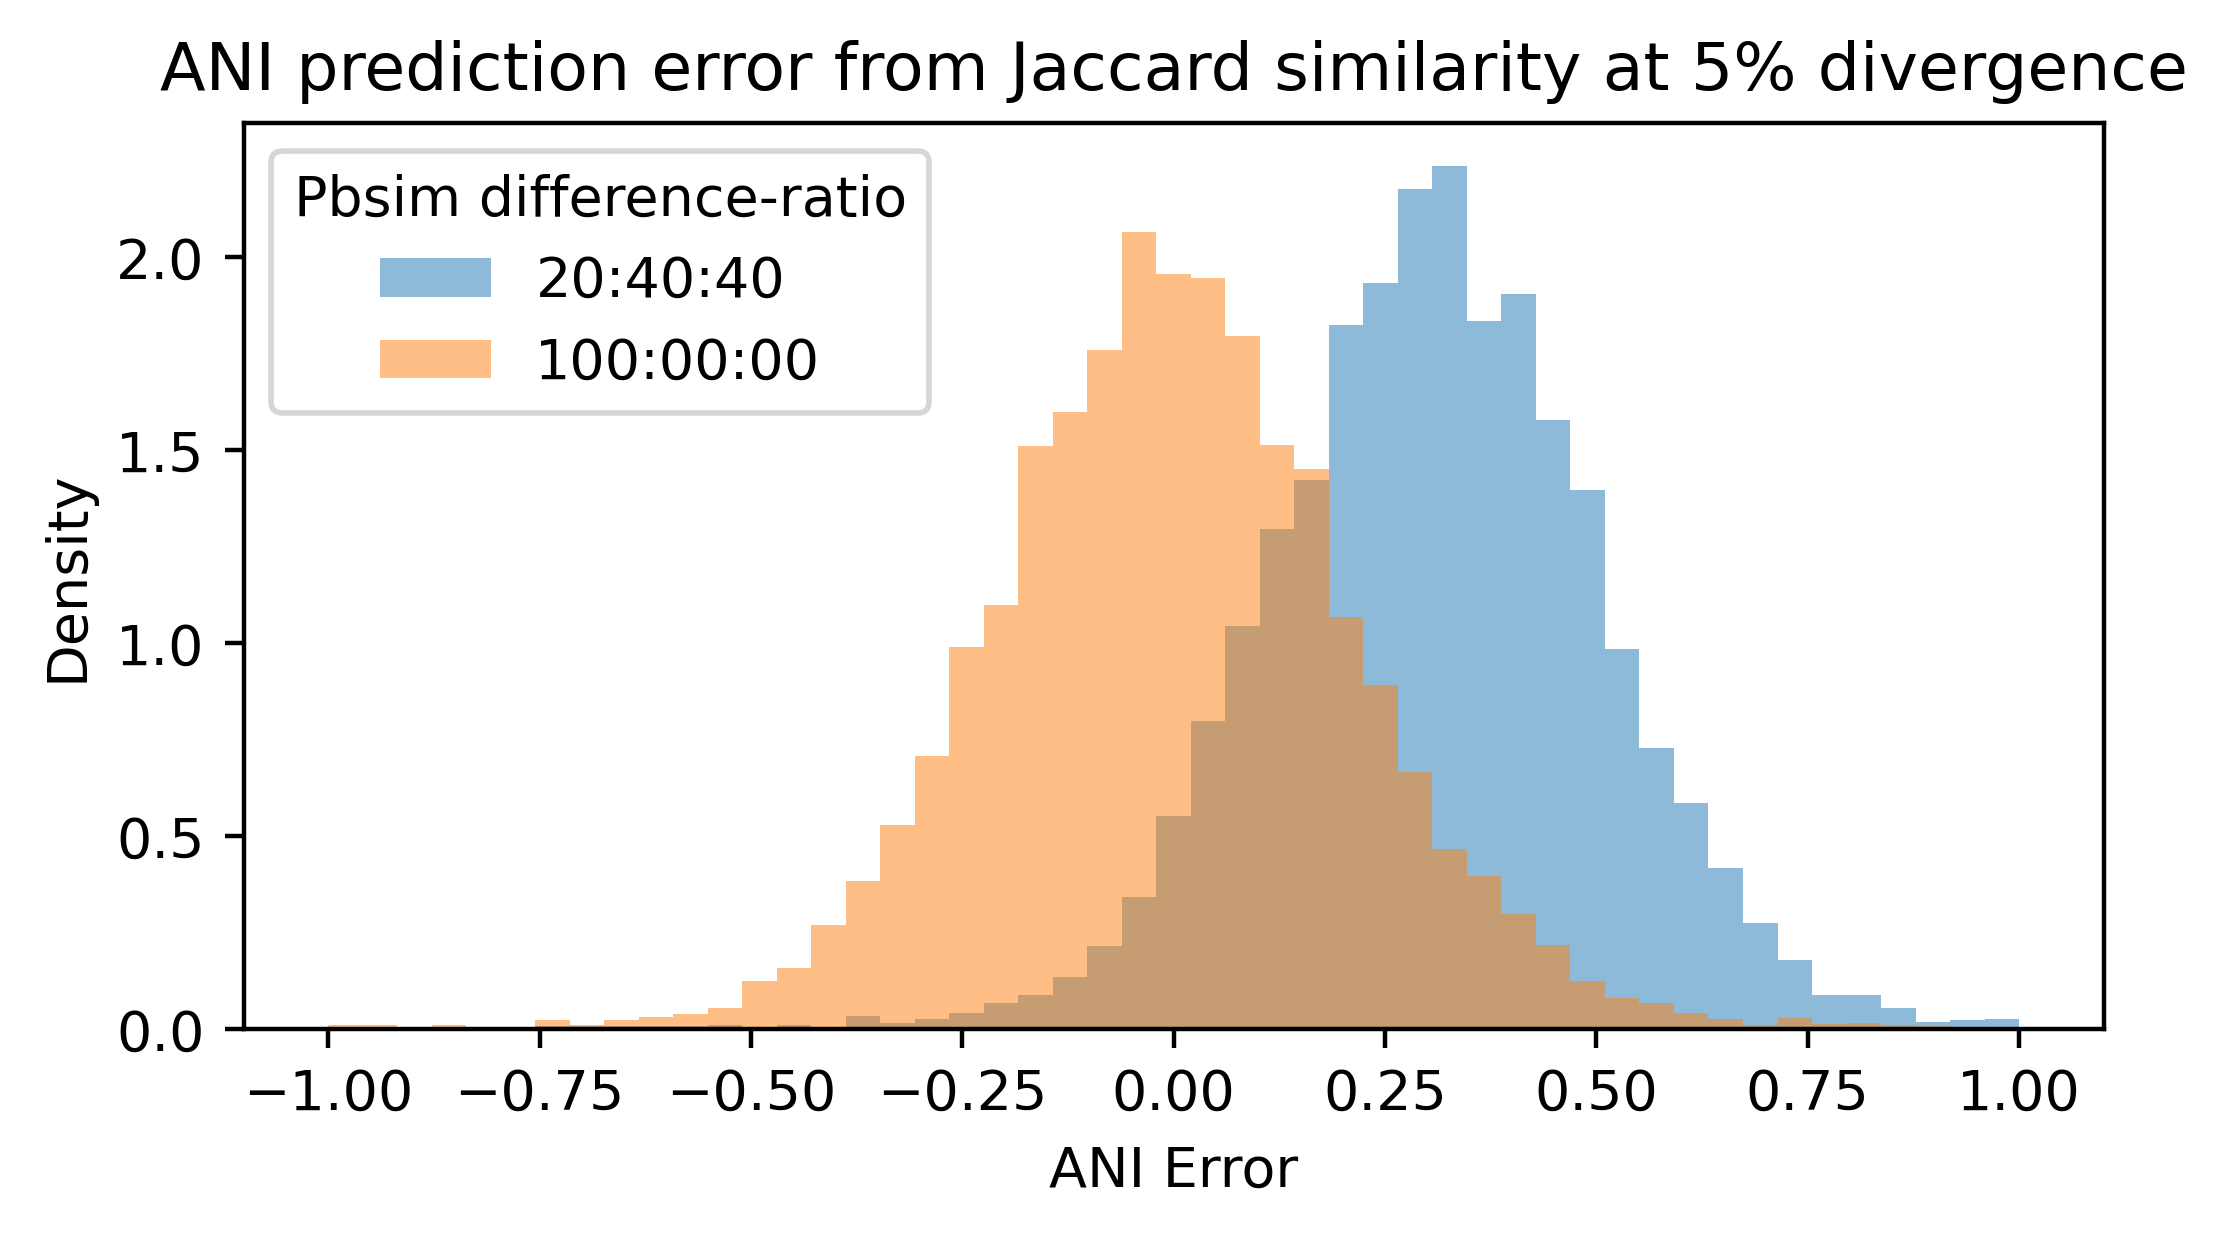

98


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

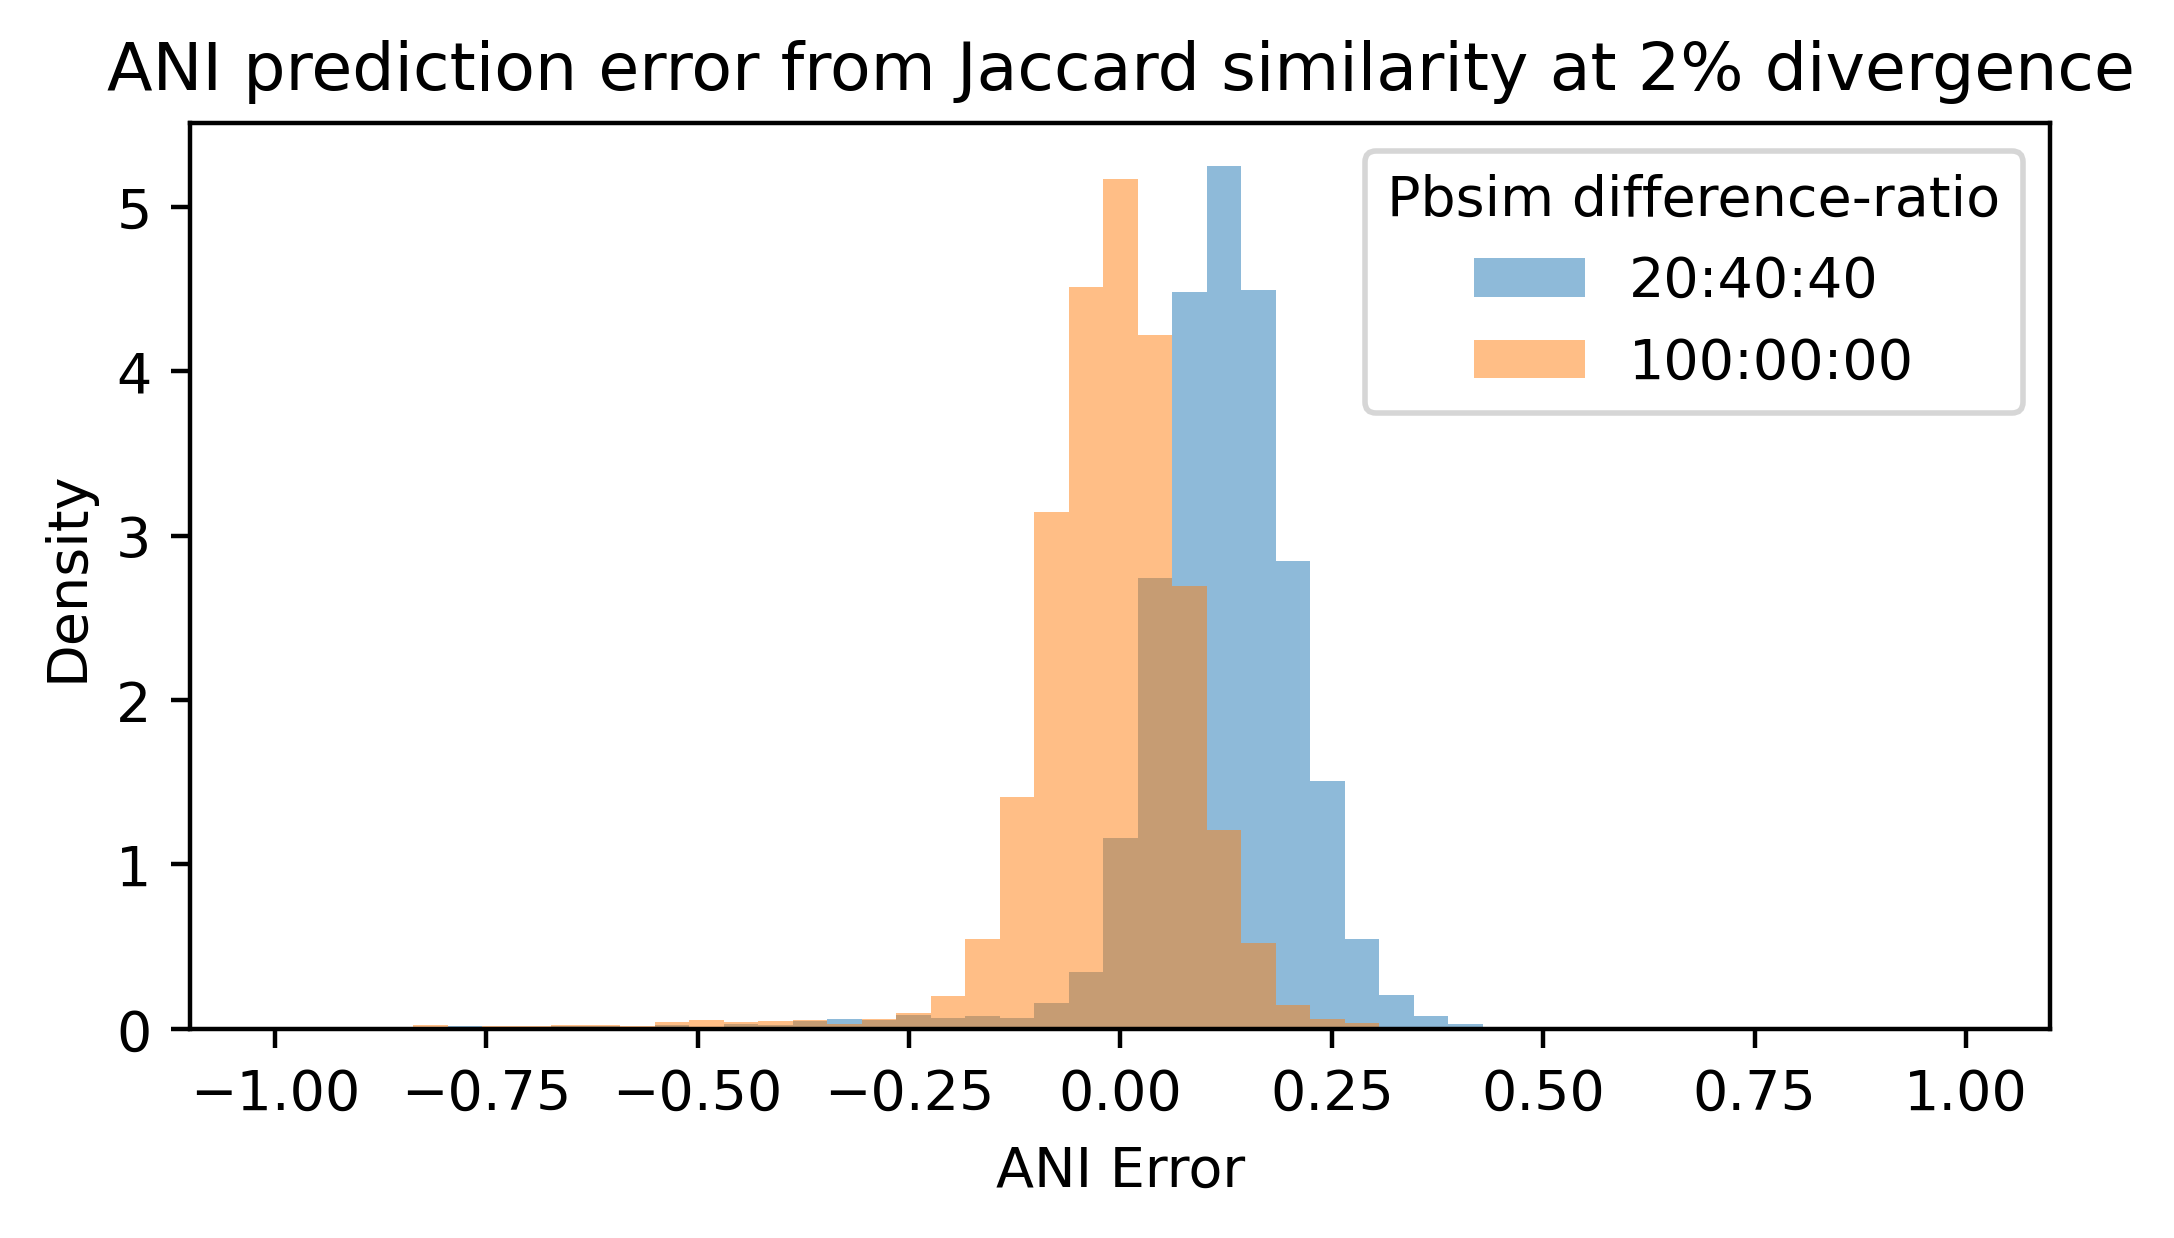

99


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

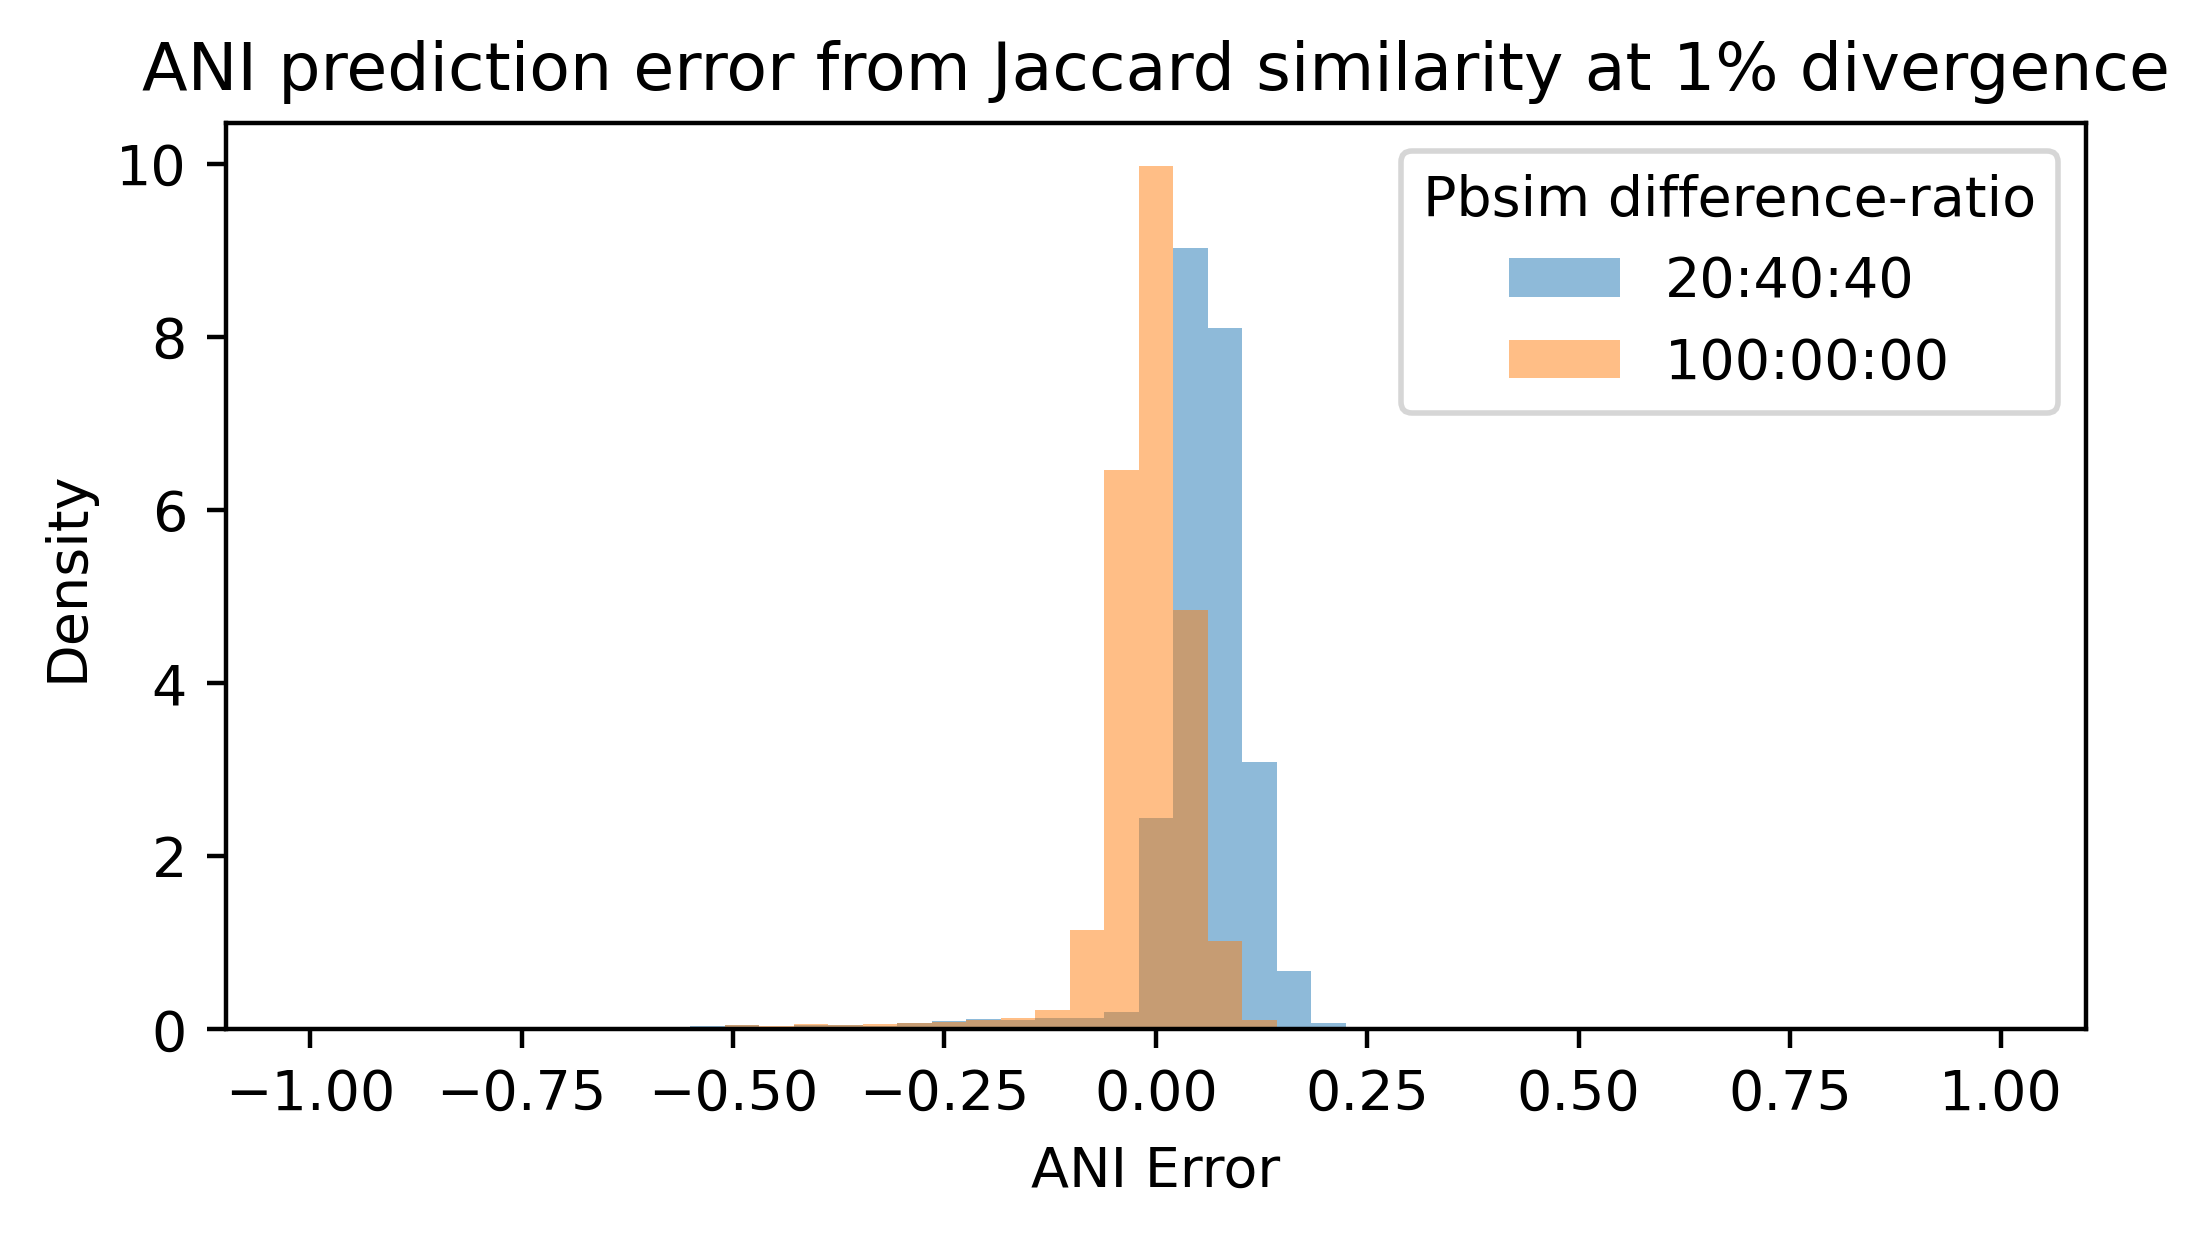

In [59]:
k = 19
def j2ani(j, k):
    return ((2*j)/(1+j))**(1/k)

errs = []
noindel_errs = []

for ANI in [95, 98, 99]:
    maf_files = glob(f"/home/Users/blk6/Data/reads/human/pbsim/ONT-{ANI}-nosd-balanced-d.05-5000_00*.maf")
    print(ANI)
    rid_to_gcANI, rid_to_J = get_gcANI_J(maf_files, .25)
    gcANI_err = []
    for rid in rid_to_J.keys():
        jc = rid_to_J[rid]
        pred_ani = 100*j2ani(jc, k)
        gcANI_err.append(pred_ani - rid_to_gcANI[rid])
    
    maf_files = glob(f"/home/Users/blk6/Data/reads/human/pbsim/ONT-{ANI}-nosd-noindel-d.05-5000_00*.maf")
    rid_to_gcANI, rid_to_J = get_gcANI_J(maf_files, .25)
    noindel_gcANI_err = []
    for rid in rid_to_J.keys():
        jc = rid_to_J[rid]
        pred_ani = 100*j2ani(jc, k)
        noindel_gcANI_err.append(pred_ani - rid_to_gcANI[rid])
        
    errs.append(stats.describe(gcANI_err))
    noindel_errs.append(stats.describe(noindel_gcANI_err))
    plt.hist(gcANI_err, label="20:40:40", alpha=0.5, bins=np.linspace(-1, 1, 50), density=True)
    plt.hist(noindel_gcANI_err, label="100:00:00", alpha=0.5, bins=np.linspace(-1, 1, 50), density=True)
    plt.legend(title="Pbsim difference-ratio")
    plt.title(f"ANI prediction error from Jaccard similarity at {(100-ANI)}% divergence")
    plt.xlabel("ANI Error")
    plt.ylabel("Density")
    plt.show()

In [65]:
for difference_ratio, stat_descs in [("20:40:40", errs), ("100:00:00", noindel_errs)]:
    latex_str = f"{difference_ratio} & "
    for desc in stat_descs:
        latex_str += f" {desc.mean :.2f} & {desc.variance :.2f} &"
    latex_str = latex_str[:-1] + " \\\\"
    print(latex_str)

20:40:40 &  0.30 & 0.05 & 0.11 & 0.02 & 0.05 & 0.01  \\
100:00:00 &  -0.00 & 0.05 & -0.02 & 0.02 & -0.02 & 0.01  \\
